In [1]:
import keras
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

/Users/alecx/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/alecx/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.models import model_from_json, load_model
import json

json_file = open('ACGAN-weights/generator.json', 'r')
generator_json = json_file.read()
json_file.close()
generator = model_from_json(generator_json)
generator.load_weights('ACGAN-weights/generator_weights.hdf5')

In [3]:
def sample_images(generator):
    r, c = 10, 3
    noise = np.random.normal(0, 1, (r * c, 128))
    sampled_labels = np.array([num for _ in range(r) for num in range(c)])
    
    gen_imgs = generator.predict([noise, sampled_labels])
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(8,6))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,:])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

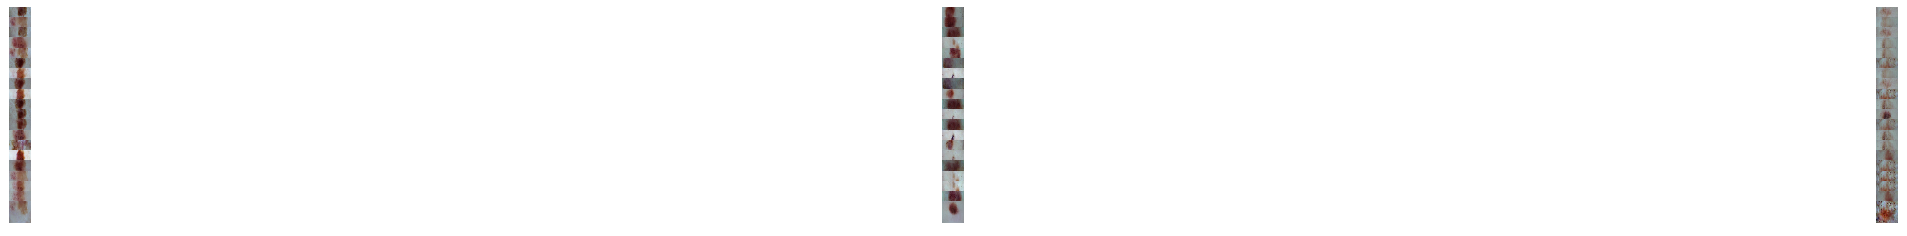

In [4]:
r, c = 20, 3
numImg = r*c

noise = np.random.normal(0, 1, (numImg, 128))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])
                          
gen_imgs = 0.5*generator.predict([noise, sampled_labels]) + 0.5

fig, axs = plt.subplots(r, c, figsize=(50,3))

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt,:,:,:])
        axs[i,j].axis('off')
        cnt += 1
fig.tight_layout()
plt.show()

In [5]:
import skimage.measure

data = np.load(".../HAMNOAUG_256.npz")
originals = data["imageList"]
labels = data["targetList"]

temp = np.empty((7133, 64, 64, 3))
for i in range(originals.shape[0]):
    temp_r = skimage.measure.block_reduce(originals[i][:,:,0], (4,4), np.mean) # (4,4) = factor of reduction
    temp_g = skimage.measure.block_reduce(originals[i][:,:,1], (4,4), np.mean)
    temp_b = skimage.measure.block_reduce(originals[i][:,:,2], (4,4), np.mean)
    temp_rgb = np.stack([temp_r, temp_g, temp_b], axis=-1)

    temp[i] = temp_rgb    
originals = temp
originals /= 255

## Get Nearest Neighbors of generated images

In [6]:
nn_sampled_labels = np.concatenate([np.zeros(3), np.ones(3), np.ones(3)+1])
nn_noise = np.random.normal(0, 1, (9, 128))

In [7]:
gen_imgs = 0.5*generator.predict([nn_noise, nn_sampled_labels]) + 0.5

In [8]:
originals_flattened = originals.flatten().reshape(7133, 12288)

In [9]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(metric="euclidean").fit(originals_flattened)

In [18]:
gen_imgs_flattened = gen_imgs.flatten().reshape(9, int(368640/30))

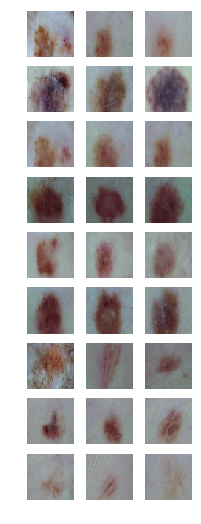

In [20]:
_, ind = nn.kneighbors(gen_imgs_flattened, n_neighbors=2)
fig, axs = plt.subplots(9, 3, figsize=(3,9))

k = 0
for imIndex in ind:

    axs[k, 0].imshow(gen_imgs[k])
    axs[k, 0].axis('off')

    j = 1
    for i in imIndex:
        axs[k, j].imshow(originals[i])
        axs[k, j].axis("off")

        j+=1

    k+=1
plt.savefig("nearestneighbors.png", dpi=250)
plt.show()

## Latent Space (Linear) Interpolation

In [10]:
numInterpolate = 6 # how many images to include in resulting interpolation

In [11]:
start_vector = np.random.normal(0, 1, (1, 128))
stop_vector = np.random.normal(0, 1, (1, 128))

class_vector = np.zeros((1,))

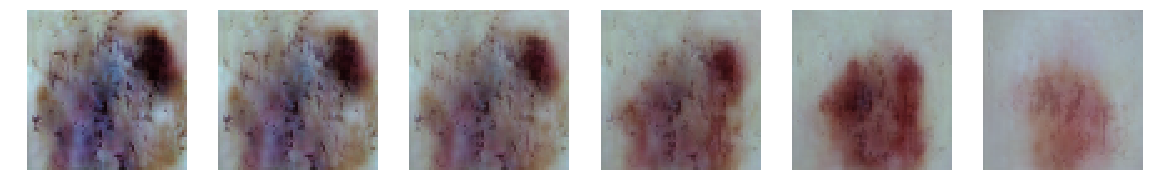

In [12]:
fig, axs = plt.subplots(1, numInterpolate, figsize=(20,5))

cnt = 0
for alpha in np.linspace(0, 1, num=numInterpolate):
    interpolated_vector = start_vector*alpha + stop_vector*(1-alpha)
    gened = 0.5*generator.predict([interpolated_vector, class_vector])[0] + 0.5
    
    # display image
    axs[cnt].imshow(gened)
    axs[cnt].axis("off")
    cnt+=1
plt.savefig("interpolation.png", dpi=400)